# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [11]:
from unityagents import UnityEnvironment
import numpy as np
import time

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

# MADDPG

* for episode = 1 to M do:
    * init random process N for action exploration
    * recieve initial state x
    * for t=1 to max-episode-length do:
        * for each agent i, select action with the current agent policy + noise
        * execute actions and observe reward r and new state
        * store (x, a,r, x') in replay buffer
        * x<-x'
        * for agent i=1 to N do:
            * sample a random minibatch of S samples $(x^j, a^j, r^j, x'^j)$ from $D$
            * run gradient descent on sampled policy gradient and update actor-critic

## hyper-parameters
* learning rate: 0.01
* $\tau = 0.01$ for soft-updates
* $\gamma = 0.95 $
* replay buffer size: $10^6$
* update frequency: 100 samples added to replay buffer
* batch-size: 1024   

In [28]:
class Agent():
    def __init__(self):
        self.epsilon=0
    def act(self, states):
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        return actions
    def reset(self):
        pass

# init agents with noise
# agent = agent.MADDPG()
agent = Agent()

In [35]:
def train(n_episodes=500):
    scores = []
    scores_deque = deque(maxlen=100)
    scores_avg = []
    max_score = 0
    
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        # get initial state
        states = env_info.vector_observations
        agent.reset()
        
        #loop over episodes
        agent_scores = np.zeros(2)
        start_time = time.time()
        while True:
            # select actions for all agents
            actions = agent.act(states)
                       
            # send action to env
            env_info = env.step(actions)[brain_name]
            
            #observe new state, reward
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
#             agent.step(states, actions, rewards, next_states, dones)
            
            #update state
            states = next_states
            
            #add agent scores individually
            agent_scores += np.array(rewards)
            
            if any(dones):
                break
        #get max score
        score = agent_scores.max()
        scores.append(score)
        scores_deque.append(score)        
        scores_avg.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tTime: {:.2f}'.format(i_episode, 
                                                                                         np.mean(scores_deque), 
                                                                                         np.mean(scores), 
                                                                                         time.time()-start_time), end="")
        if np.mean(scores_deque)>max_score:
            max_score = np.mean(scores_deque)
#             torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth'.format(i_episode))
#             torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth'.format(i_episode))
            
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tMax score: {:.2f} \tEpsilon: {:.2f} \tTime: {:.2f}/per episode'.format(i_episode, 
                                                                                                                                np.mean(scores_deque), 
                                                                                                                                np.max(scores_deque), 
                                                                                                                                agent.epsilon, 
                                                                                                                                time.time()-start_time))   
        
    return scores, scores_avg

In [36]:
scores, moving_averages = train()

Episode 10	Average Score: 0.01 	Max score: 0.10 	Epsilon: 0.00 	Time: 0.03/per episode
Episode 20	Average Score: 0.02 	Max score: 0.10 	Epsilon: 0.00 	Time: 0.13/per episode
Episode 30	Average Score: 0.02 	Max score: 0.10 	Epsilon: 0.00 	Time: 0.03/per episode
Episode 40	Average Score: 0.02 	Max score: 0.10 	Epsilon: 0.00 	Time: 0.07/per episode
Episode 50	Average Score: 0.02 	Max score: 0.10 	Epsilon: 0.00 	Time: 0.07/per episode
Episode 60	Average Score: 0.02 	Max score: 0.10 	Epsilon: 0.00 	Time: 0.03/per episode
Episode 70	Average Score: 0.02 	Max score: 0.10 	Epsilon: 0.00 	Time: 0.03/per episode
Episode 80	Average Score: 0.02 	Max score: 0.20 	Epsilon: 0.00 	Time: 0.04/per episode
Episode 90	Average Score: 0.02 	Max score: 0.20 	Epsilon: 0.00 	Time: 0.03/per episode
Episode 100	Average Score: 0.02 	Max score: 0.20 	Epsilon: 0.00 	Time: 0.03/per episode
Episode 110	Average Score: 0.02 	Max score: 0.20 	Epsilon: 0.00 	Time: 0.03/per episode
Episode 120	Average Score: 0.02 	Max scor

In [39]:
env.close()

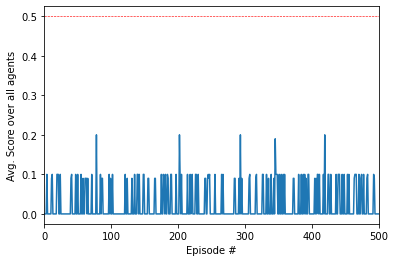

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
ax.plot([0,500],[0.5,0.5], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 500)
plt.ylabel('Avg. Score over all agents')
plt.xlabel('Episode #')
plt.show()
# plt.tight_layout()
# plt.savefig('scores.eps')

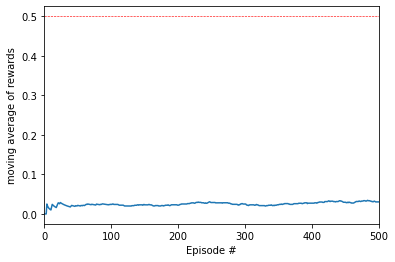

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(moving_averages)+1), moving_averages)
ax.plot([0,500],[0.5,0.5], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 500)
plt.ylabel('moving average of rewards')
plt.xlabel('Episode #')
plt.show()
# plt.tight_layout()
# plt.savefig('moving_average.eps')